# Analysis of hematopoiesis dataset from scNT-seq

Here you will learn how to analyze a one-shot dataset from scNT-seq using the CSP model with steady-state assumptions (CSPss) and comparing it to Dynamo method.

In [1]:
import dynamo as dyn
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load and preprocess the data

In [2]:
filename = './data/hsc_raw_with_metadata.h5ad'
adata_hsc_raw = dyn.read_h5ad(filename)

In [3]:
adata_hsc_raw.obs['time'] = adata_hsc_raw.obs['time'].astype(str)
adata_hsc_raw.obs.loc[adata_hsc_raw.obs['time'] == 'dmso', 'time'] = -1
adata_hsc_raw.obs['time'] = adata_hsc_raw.obs['time'].astype(float)
adata_hsc_raw = adata_hsc_raw[adata_hsc_raw.obs.time != -1, :]

selected_genes_to_use = adata_hsc_raw.uns["genes_to_use"]

In [4]:
dyn.pp.recipe_monocle(
    adata_hsc_raw,
    tkey="time",
    experiment_type="one-shot",
    genes_to_use=selected_genes_to_use,
    n_top_genes=len(selected_genes_to_use),
    # feature_selection_layer="new",
    maintain_n_top_genes=True,
    keep_raw_layers=True,
)
dyn.tl.reduceDimension(adata_hsc_raw)
dyn.tl.moments(adata_hsc_raw, group="time")
adata_hsc_raw.uns["pp"]["has_splicing"] = False

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [41.9330s]


## Use CSPss and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [5]:
pca_genes = adata_hsc_raw.var.use_for_pca
new_expr = adata_hsc_raw[:, pca_genes].layers["M_n"]
M_s = adata_hsc_raw.layers["M_s"][:, pca_genes]
t = adata_hsc_raw.obs.time.astype(float)
time_3_cells = adata_hsc_raw.obs.time == 3
time_5_cells = adata_hsc_raw.obs.time == 5

del adata_hsc_raw.layers['M_uu'], adata_hsc_raw.layers['M_us'], adata_hsc_raw.layers['M_tt']
del adata_hsc_raw.layers['M_tn'], adata_hsc_raw.layers['M_ss'], adata_hsc_raw.layers['M_nn']
del adata_hsc_raw.layers['M_CSP_u'], adata_hsc_raw.layers['M_CSP_s']

def alpha_minus_gamma_s(new, gamma, t, M_s):
    # equation: alpha = new / (1 - e^{-rt}) * r
    alpha = new.A.T / (1 - np.exp(-gamma.values[:, None] * t.values[None, :])) * gamma.values[:, None]

    gamma_s = gamma.values[:, None] * M_s.A.T
    # alpha_minus_gamma_s = alpha/0.83 - gamma_s
    alpha_minus_gamma_s = alpha - gamma_s
    return alpha_minus_gamma_s

In [6]:
adata_hsc_raw_CSPss = adata_hsc_raw.copy()
del adata_hsc_raw
adata_hsc_raw_dynamo = adata_hsc_raw_CSPss.copy()

In [7]:
# for CSP with steady state
adata_hsc_raw_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(adata_hsc_raw_CSPss, group="time",
                est_method="CSP4ML_CSPss",
                model="deterministic")
time_3_gamma_CSPss = adata_hsc_raw_CSPss[:, pca_genes].var['time_3.0_gamma'].astype(float)
time_5_gamma_CSPss = adata_hsc_raw_CSPss[:, pca_genes].var['time_5.0_gamma'].astype(float)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group time), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [3.8328s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1755it [00:00, 2087.69it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 1755it [00:00, 2452.62it/s]


(1755, 1)
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [2.2248s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1755it [00:00, 2152.68it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 1755it [00:00, 2705.18it/s]


(1755, 1)


In [8]:
time_3_velocity_n_CSPss = alpha_minus_gamma_s(new_expr[time_3_cells, :], time_3_gamma_CSPss, t[time_3_cells], M_s[time_3_cells, :])
time_5_velocity_n_CSPss = alpha_minus_gamma_s(new_expr[time_5_cells, :], time_5_gamma_CSPss, t[time_5_cells], M_s[time_5_cells, :])

velocity_n_CSPss = adata_hsc_raw_CSPss.layers["velocity_N"].copy()

valid_velocity_n_CSPss = velocity_n_CSPss[:, pca_genes].copy()
valid_velocity_n_CSPss[time_3_cells, :] = time_3_velocity_n_CSPss.T
valid_velocity_n_CSPss[time_5_cells, :] = time_5_velocity_n_CSPss.T
velocity_n_CSPss[:, pca_genes] = valid_velocity_n_CSPss.copy()

adata_hsc_raw_CSPss.layers["velocity_alpha_minus_gamma_s"] = velocity_n_CSPss.copy()

dyn.tl.cell_velocities(
    adata_hsc_raw_CSPss,
    enforce=True,
    X=adata_hsc_raw_CSPss.layers["M_t"],
    V=adata_hsc_raw_CSPss.layers["velocity_alpha_minus_gamma_s"],
    method="cosine",
)

|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] finished [365.3459s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5800s]


AnnData object with n_obs × n_vars = 1947 × 21585
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'time_3.0_alpha', 'time_3.0_a', 'time_3.0_b', 'time_3.0_alpha_a', 'time_3.0_alpha_i', 'time_3.0_beta', 'time_3.0_p_half_life', 'time_3.0_gamma', 'time_3.0_half_life', 'time_3.0_cost', 'time_3.0_logLL', 'time_3.0_gamma_k', 'time_3.0_gamma_r2', 'time_3.0_gamma_r2_raw', 'time_3.0_prob_off', 'time_5.0_alpha', 'time_5.0_beta', 'time_5.0_gamma', 'time_5.0_a', 'time_5.0_b', 'time_5.0_alpha_a', 'time_5.0_alpha_i', 'time_5.0_half_life', 'time_

In [9]:
# for Dynamo
dyn.tl.dynamics(adata_hsc_raw_dynamo, group="time",
                one_shot_method="sci_fate",
                model="deterministic")
time_3_gamma_dynamo = adata_hsc_raw_dynamo[:, pca_genes].var['time_3.0_gamma'].astype(float)
time_5_gamma_dynamo = adata_hsc_raw_dynamo[:, pca_genes].var['time_5.0_gamma'].astype(float)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group time), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [3.0889s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████████████| 1755/1755 [00:00<00:00, 76116.55it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [2.8239s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████████████| 1755/1755 [00:00<00:00, 72500.06it/s]


In [10]:
time_3_velocity_n_dynamo = alpha_minus_gamma_s(new_expr[time_3_cells, :], time_3_gamma_dynamo, t[time_3_cells], M_s[time_3_cells, :])
time_5_velocity_n_dynamo = alpha_minus_gamma_s(new_expr[time_5_cells, :], time_5_gamma_dynamo, t[time_5_cells], M_s[time_5_cells, :])

velocity_n_dynamo = adata_hsc_raw_dynamo.layers["velocity_N"].copy()

valid_velocity_n_dynamo = velocity_n_dynamo[:, pca_genes].copy()
valid_velocity_n_dynamo[time_3_cells, :] = time_3_velocity_n_dynamo.T
valid_velocity_n_dynamo[time_5_cells, :] = time_5_velocity_n_dynamo.T
velocity_n_dynamo[:, pca_genes] = valid_velocity_n_dynamo.copy()

adata_hsc_raw_dynamo.layers["velocity_alpha_minus_gamma_s"] = velocity_n_dynamo.copy()

dyn.tl.cell_velocities(
    adata_hsc_raw_dynamo,
    enforce=True,
    X=adata_hsc_raw_dynamo.layers["M_t"],
    V=adata_hsc_raw_dynamo.layers["velocity_alpha_minus_gamma_s"],
    method="cosine",
)

|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] finished [370.6538s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5204s]


AnnData object with n_obs × n_vars = 1947 × 21585
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'time_3.0_alpha', 'time_3.0_beta', 'time_3.0_gamma', 'time_3.0_half_life', 'time_3.0_alpha_b', 'time_3.0_alpha_r2', 'time_3.0_gamma_b', 'time_3.0_gamma_r2', 'time_3.0_gamma_logLL', 'time_3.0_delta_b', 'time_3.0_delta_r2', 'time_3.0_bs', 'time_3.0_bf', 'time_3.0_uu0', 'time_3.0_ul0', 'time_3.0_su0', 'time_3.0_sl0', 'time_3.0_U0', 'time_3.0_S0', 'time_3.0_total0', 'time_3.0_beta_k', 'time_3.0_gamma_k', 'time_5.0_alpha', 'time_5.0_beta',

## Visualization

Change the settings for better visualization:

In [17]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
# path = './one-shot/streamline/'
path = './rev_figures/figure2/streamline/'

### Streamline plots in UMAP space

<Figure size 600x400 with 0 Axes>

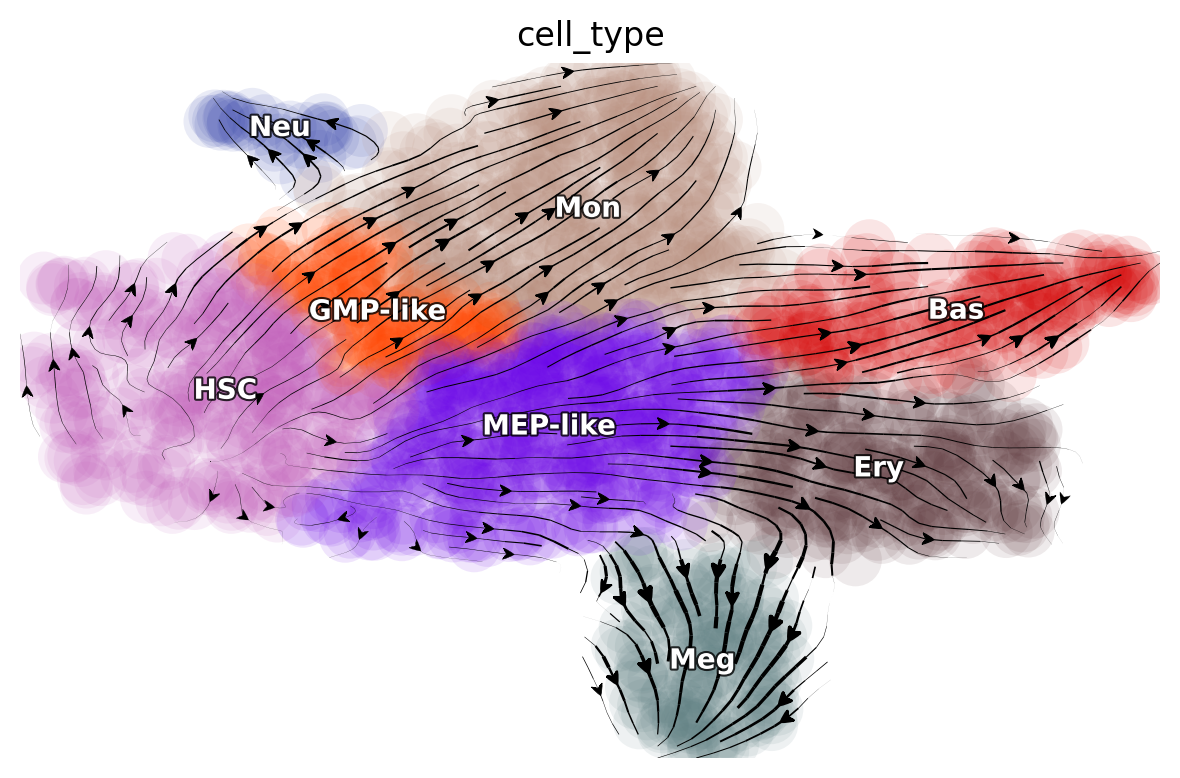

In [20]:
# CSP with steady-state
dyn.pl.streamline_plot(adata_hsc_raw_CSPss, color=["cell_type"], ncols=4, basis='umap', save_show_or_return='show',
                       save_kwargs={'prefix': 'hsc_umap_cspss', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

<Figure size 600x400 with 0 Axes>

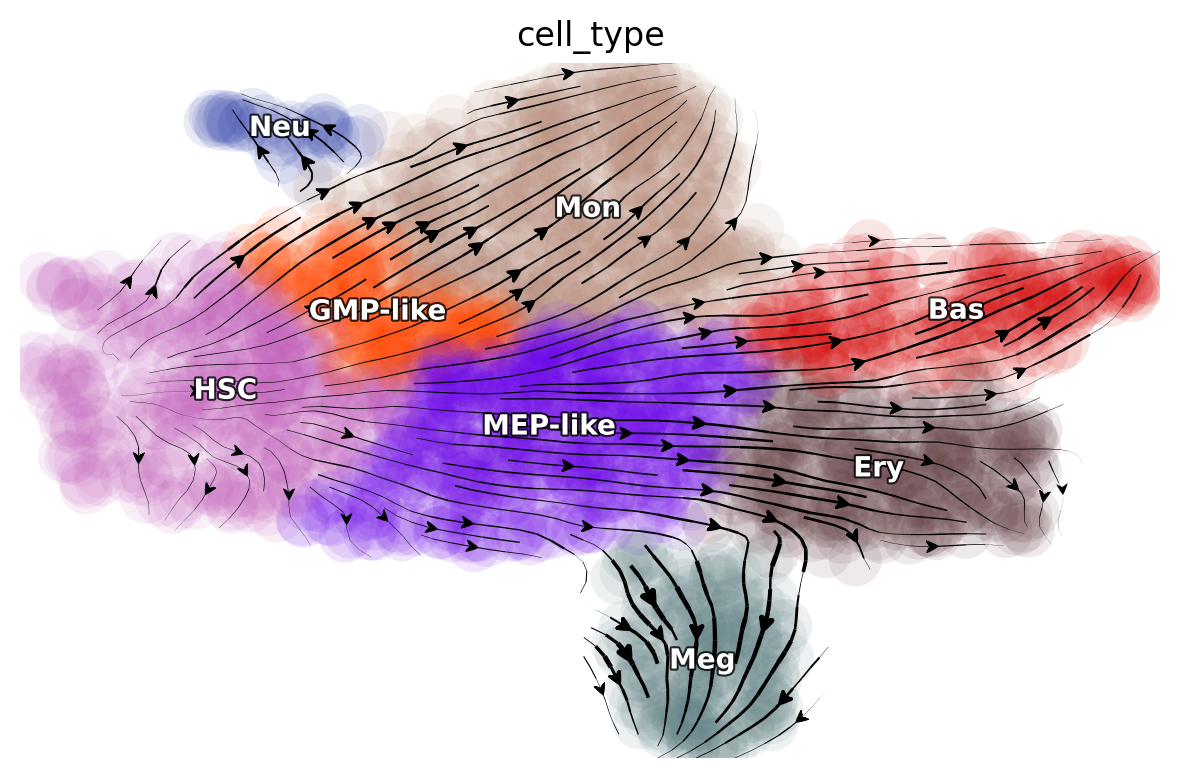

In [13]:
# Dynamo
dyn.pl.streamline_plot(adata_hsc_raw_dynamo, color=["cell_type"], ncols=4, basis='umap', save_show_or_return='show',
                       save_kwargs={'prefix': 'hsc_umap_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

### Plot the inferred results of $\gamma_{t}$ of the two methods

In [14]:
gamma_CSPss = (time_3_gamma_CSPss + time_5_gamma_CSPss)/2
gamma_Dynamo = (time_3_gamma_dynamo + time_5_gamma_dynamo)/2

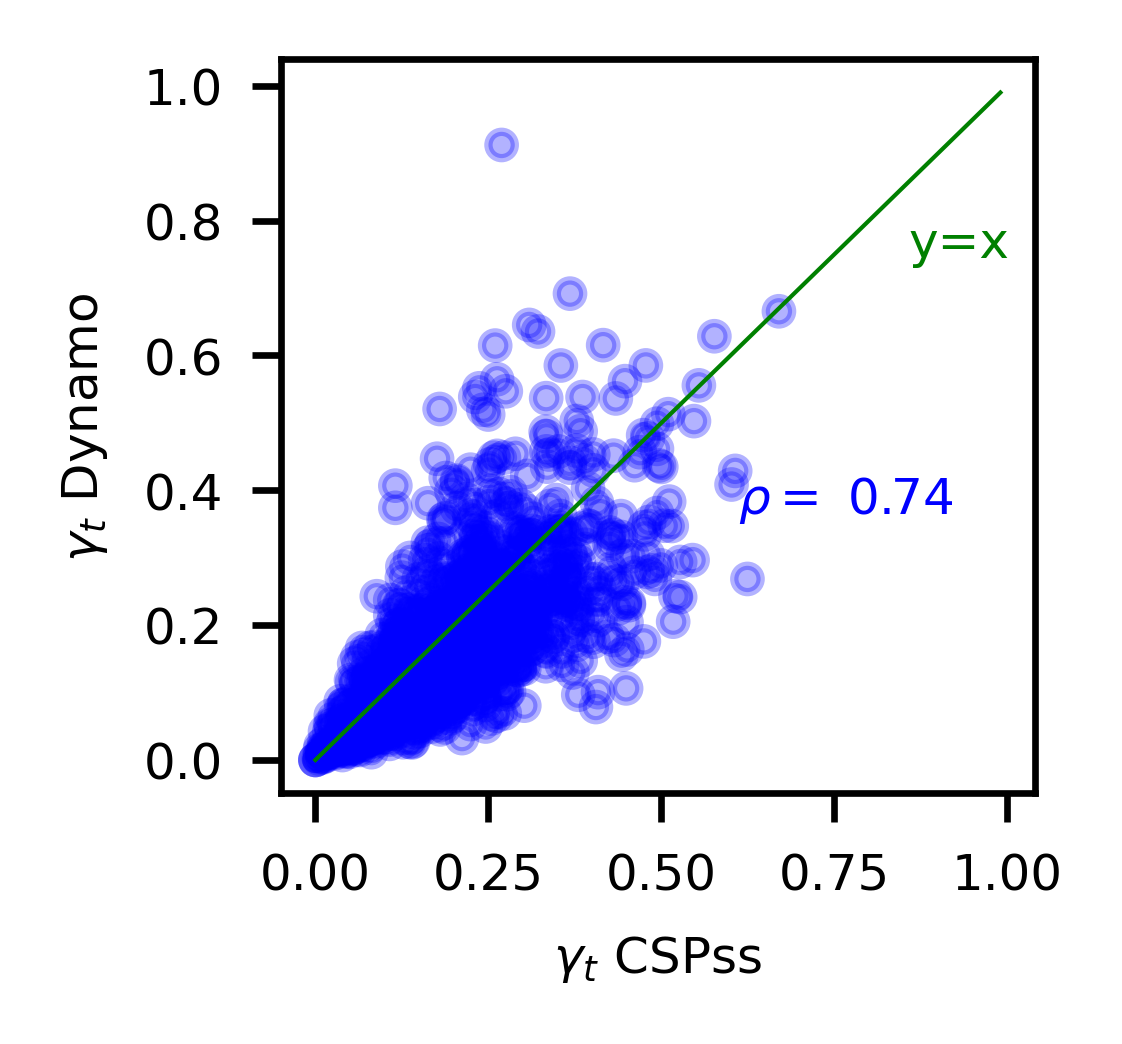

In [16]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

gamma_CSPss = gamma_CSPss.astype('float')
gamma_Dynamo = gamma_Dynamo.astype('float')


range_min = 0
range_max = 1
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_CSPss), np.isfinite(gamma_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_CSPss[index_no_nan], gamma_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_CSPss, gamma_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
# plt.savefig('./one-shot/comp/hsc.pdf',dpi=dpi, bbox_inches="tight")
plt.savefig('./rev_figures/figure2/hsc.pdf',dpi=dpi, bbox_inches="tight")
plt.show()